# Assignment 1
Entropy can be used as a feature in most of our machine learning applications. For this assignment try to extract the entropy of an image to classify damage vs undamaged satellite images.

Instructions:
1. **Preprocess the images**: Convert each RGB satellite image to grayscale.
2. **Apply the Shannon entropy formula** to compute the entropy of:
   - The whole image **or**
   - Multiple sliding windows across the image (for localized entropy estimation).
3. **Experiment with different parameters**:
   - Vary the **window size** (e.g., 8x8, 16x16, etc.)
   - Try **thresholding** the grayscale values or binning intensity levels
4. **Extract entropy-based features** (e.g., mean, variance, max entropy across windows).
5. **Train a classifier** (e.g., logistic regression, SVM, random forest) to predict if the image is **damaged** or **undamaged** based solely on entropy-derived features.
6. **Evaluate the model** using accuracy, precision, recall, and/or confusion matrix.

Hint: You have two controllable dimensions in your feature extraction pipeline:
- Window size - affects the granularity of entropy localization
- Grayscale binning or thresholds - affects how patterns and noise are detected

### Questions:

1. Which entropy features (e.g., mean entropy, max entropy) were most useful for classification?
2. How does changing the window size affect your classifier’s performance?
3. Did thresholding or binning the grayscale values help or hurt entropy-based differentiation?
4. Is there a noticeable difference in entropy distribution between damaged and undamaged images?
5. How do you think can entropy-based classification compare to using raw pixel values or CNNs?

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.color import rgb2gray
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


### Preprocess images

In [2]:
def preprocess_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = imread(os.path.join(image_folder, filename))
            if img.ndim == 3 and img.shape[2] == 3:
                img = rgb2gray(img)
            images.append(img)
    return images

### Shannon entropy calculation

In [3]:
def shannon_entropy(window):
    flat_window = window.flatten()
    freqs = Counter(flat_window)
    total = len(flat_window)
    probs = [f / total for f in freqs.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

### Localized entropies

In [4]:
def compute_entropy_in_windows(image, window_size):
    height, width = image.shape
    entropy_map = np.zeros((height - window_size[0] + 1, width - window_size[1] + 1))
    for i in range(entropy_map.shape[0]):
        for j in range(entropy_map.shape[1]):
            window = image[i:i + window_size[0], j:j + window_size[1]]
            entropy_map[i, j] = shannon_entropy(window)
    return entropy_map

### Extract entropy features


In [5]:
def extract_entropy_features_for_image(image, window_size=None, bins=None, threshold=None):    
    if bins is not None:
        image = np.digitize(image, bins=np.linspace(0, 1, bins + 1)) / bins
        
    if threshold is not None:
        image = (image > threshold).astype(float)
    
    if window_size is not None:
        entropy_map = compute_entropy_in_windows(image, window_size)
        stats = [np.mean(entropy_map), np.std(entropy_map), np.min(entropy_map), np.max(entropy_map)]
    else:
        global_entropy = shannon_entropy(image)
        stats = [global_entropy, 0, global_entropy, global_entropy]
    
    return stats


### Classification

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

def classify_with_params(damaged_images,
                         undamaged_images,
                         window_size=None,
                         threshold=None,
                         bins=None,
                         model_type='logistic',
                         n_splits=5
                         ):
    all_data = []

    for img in damaged_images:
        features = extract_entropy_features_for_image(img, window_size, bins, threshold)
        all_data.append(features + ['Damaged'])

    for img in undamaged_images:
        features = extract_entropy_features_for_image(img, window_size, bins, threshold)
        all_data.append(features + ['Undamaged'])

    df = pd.DataFrame(all_data, columns=['Mean Entropy', 
                                         'Std Entropy', 
                                         'Min Entropy', 
                                         'Max Entropy', 
                                         'Label'
                                         ])

    X = df[['Mean Entropy', 'Std Entropy', 'Min Entropy', 'Max Entropy']]
    y = df['Label'].map({'Damaged': 1, 'Undamaged': 0})

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accs, precs, recs, f1s = [], [], [], []
    cms = np.zeros((2, 2))

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if model_type == 'logistic':
            model = LogisticRegression(max_iter=1000)
        elif model_type == 'svm':
            model = SVC(kernel='linear')
        elif model_type == 'random_forest':
            model = RandomForestClassifier()
        else:
            raise ValueError("Model must be 'logistic', 'svm', or 'random_forest'")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        cms += confusion_matrix(y_test, y_pred)

    acc = np.mean(accs)
    prec = np.mean(precs)
    rec = np.mean(recs)
    f1 = np.mean(f1s)

    print(f"Window={window_size} | Threshold={threshold} | Bins={bins} | Model={model_type}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(f"Confusion Matrix (summed over folds):\n{cms.astype(int)}")

    return model, acc, prec, rec, f1, cms


### Load folders

In [7]:
damaged_folder = '/Users/jandenvervalera/Documents/Acads/complexity-science/Data/Assignment 1/damaged'
undamaged_folder = '/Users/jandenvervalera/Documents/Acads/complexity-science/Data/Assignment 1/undamaged'
damaged_images = preprocess_images(damaged_folder)
undamaged_images = preprocess_images(undamaged_folder)

### Logistic Regression


#### Window Size Adjustments

In [8]:
window_sizes = [(i, i) for i in range(2, 17)]
window_sizes.extend([(32,32),(64,64),None])

accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []
feature_importances = []

for window_size in window_sizes:
    _, acc, prec, rec, f1, cm = classify_with_params(
        damaged_images,
        undamaged_images,
        window_size=window_size,
        model_type='logistic'
    )
    accuracies.append((window_size, acc))
    precisions.append((window_size, prec))
    recalls.append((window_size, rec))
    f1_scores.append((window_size, f1))
    conf_matrices.append((window_size, cm))


Window=(2, 2) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.7833 | Precision: 0.7804 | Recall: 0.8000 | F1: 0.7851
Confusion Matrix (summed over folds):
[[46 14]
 [12 48]]
Window=(3, 3) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.6750 | Precision: 0.6903 | Recall: 0.6500 | F1: 0.6567
Confusion Matrix (summed over folds):
[[42 18]
 [21 39]]
Window=(4, 4) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.7083 | Precision: 0.7269 | Recall: 0.7167 | F1: 0.6961
Confusion Matrix (summed over folds):
[[42 18]
 [17 43]]
Window=(5, 5) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.6750 | Precision: 0.6956 | Recall: 0.7167 | F1: 0.6831
Confusion Matrix (summed over folds):
[[38 22]
 [17 43]]
Window=(6, 6) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.7333 | Precision: 0.7632 | Recall: 0.7500 | F1: 0.7409
Confusion Matrix (summed over folds):
[[43 17]
 [15 45]]
Window=(7, 7) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.7250 | P

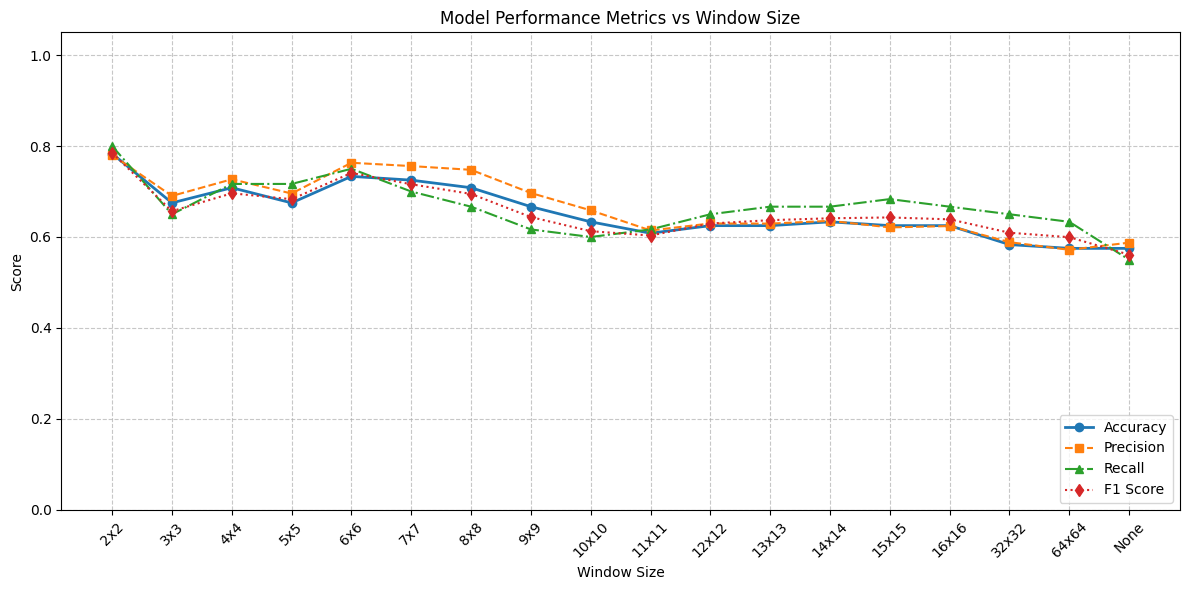

In [9]:
window_labels = ['None' if w is None else f"{w[0]}x{w[1]}" for w, _ in accuracies]
acc_values = [acc for _, acc in accuracies]
prec_values = [prec for _, prec in precisions]
rec_values = [rec for _, rec in recalls]
f1_values = [f1 for _, f1 in f1_scores]

plt.figure(figsize=(12, 6))
plt.plot(window_labels, acc_values, label='Accuracy', marker='o', linewidth=2)
plt.plot(window_labels, prec_values, label='Precision', marker='s', linestyle='--')
plt.plot(window_labels, rec_values, label='Recall', marker='^', linestyle='-.')
plt.plot(window_labels, f1_values, label='F1 Score', marker='d', linestyle=':')

plt.title("Model Performance Metrics vs Window Size")
plt.xlabel("Window Size")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Overall performace sees a gradual decline as window sizes increases. For assessing the impact of thresholding, I will be using a 2x2 window since it hase the best performace.

#### Threshold Adjustments using 2x2 Window

In [10]:
results = []
threshold_range = np.arange(0.1, 1.0, 0.1)

for threshold in threshold_range:
    model, acc, prec, rec, f1, cm = classify_with_params(
        damaged_images,
        undamaged_images,
        window_size=(2,2),
        threshold=threshold,
        bins=None,
        model_type='logistic',
        n_splits=5
    )
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

results_df = pd.DataFrame(results)

Window=(2, 2) | Threshold=0.1 | Bins=None | Model=logistic
Accuracy: 0.7750 | Precision: 0.8288 | Recall: 0.6833 | F1: 0.7465
Confusion Matrix (summed over folds):
[[52  8]
 [19 41]]
Window=(2, 2) | Threshold=0.2 | Bins=None | Model=logistic
Accuracy: 0.5583 | Precision: 0.5743 | Recall: 0.5667 | F1: 0.5662
Confusion Matrix (summed over folds):
[[33 27]
 [26 34]]
Window=(2, 2) | Threshold=0.30000000000000004 | Bins=None | Model=logistic
Accuracy: 0.8500 | Precision: 0.9292 | Recall: 0.7667 | F1: 0.8347
Confusion Matrix (summed over folds):
[[56  4]
 [14 46]]
Window=(2, 2) | Threshold=0.4 | Bins=None | Model=logistic
Accuracy: 0.7583 | Precision: 0.8065 | Recall: 0.7333 | F1: 0.7609
Confusion Matrix (summed over folds):
[[47 13]
 [16 44]]
Window=(2, 2) | Threshold=0.5 | Bins=None | Model=logistic
Accuracy: 0.4333 | Precision: 0.4384 | Recall: 0.5500 | F1: 0.4767
Confusion Matrix (summed over folds):
[[19 41]
 [27 33]]
Window=(2, 2) | Threshold=0.6 | Bins=None | Model=logistic
Accuracy: 

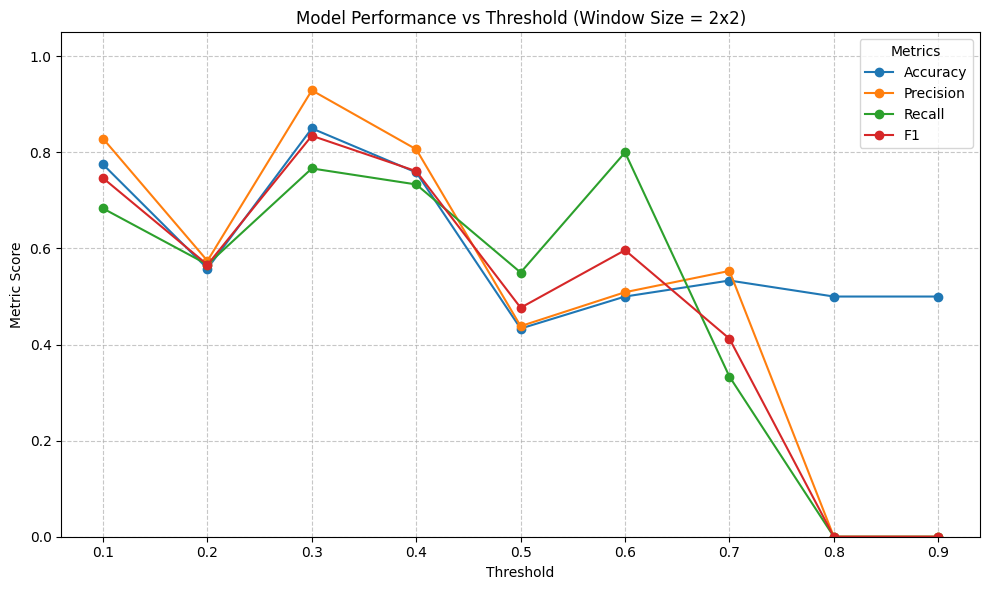

In [11]:
plt.figure(figsize=(10, 6))

for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    plt.plot(results_df['Threshold'], results_df[metric], marker='o', label=metric)

plt.title('Model Performance vs Threshold (Window Size = 2x2)')
plt.xlabel('Threshold')
plt.ylabel('Metric Score')
plt.ylim(0, 1.05)
plt.xticks(threshold_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

**No thresholding results:**

Window=(2, 2) | Threshold=None | Bins=None | Model=logistic

Accuracy: 0.7833 | Precision: 0.7804 | Recall: 0.8000 | F1: 0.7851

Confusion Matrix (summed over folds):

[[46 14]

 [12 48]]

**Best results with threshold:**

Window=(2, 2) | Threshold=0.30000000000000004 | Bins=None | Model=logistic

Accuracy: 0.8500 | Precision: 0.9292 | Recall: 0.7667 | F1: 0.8347

Confusion Matrix (summed over folds):

[[56  4]

 [14 46]]

Using a 2×2 window with a 0.3 threshold significantly improved model performance
- Increased accuracy to 85%, precision to 92.92%, and F1-score to 83.47%
- Recall took a small downswing from 80% to 76.67%.

False positives dropped sharply (14 to 4)
- This enhances the model's confidence in identifying damage.

Although recall dipped slightly from the no-threshold baseline, the overall F1 score rose to 83.47% which makes this setup a strong, precision-focused configuration—ideal if minimizing false alarms is the objective.

Most other threshold configurations were not ideal, though. This implies that there might be a chance to increase model performance with the ***right*** threshold

#### Bin Adjustments using 2x2 Window

In [12]:
bins_range = range(2, 11)
results = []

for bins in bins_range:
    model, acc, prec, rec, f1, cm = classify_with_params(
        damaged_images,
        undamaged_images,
        window_size=(2, 2),
        threshold=None,
        bins=bins,
        model_type='logistic'
    )
    results.append({
        'Bins': bins,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })
    
results_df = pd.DataFrame(results)

Window=(2, 2) | Threshold=None | Bins=2 | Model=logistic
Accuracy: 0.4333 | Precision: 0.4384 | Recall: 0.5500 | F1: 0.4767
Confusion Matrix (summed over folds):
[[19 41]
 [27 33]]
Window=(2, 2) | Threshold=None | Bins=3 | Model=logistic
Accuracy: 0.8333 | Precision: 0.9118 | Recall: 0.7500 | F1: 0.8190
Confusion Matrix (summed over folds):
[[55  5]
 [15 45]]
Window=(2, 2) | Threshold=None | Bins=4 | Model=logistic
Accuracy: 0.7583 | Precision: 0.7614 | Recall: 0.7667 | F1: 0.7606
Confusion Matrix (summed over folds):
[[45 15]
 [14 46]]
Window=(2, 2) | Threshold=None | Bins=5 | Model=logistic
Accuracy: 0.6917 | Precision: 0.7273 | Recall: 0.6167 | F1: 0.6588
Confusion Matrix (summed over folds):
[[46 14]
 [23 37]]
Window=(2, 2) | Threshold=None | Bins=6 | Model=logistic
Accuracy: 0.7333 | Precision: 0.7216 | Recall: 0.7500 | F1: 0.7286
Confusion Matrix (summed over folds):
[[43 17]
 [15 45]]
Window=(2, 2) | Threshold=None | Bins=7 | Model=logistic
Accuracy: 0.7500 | Precision: 0.7737 |

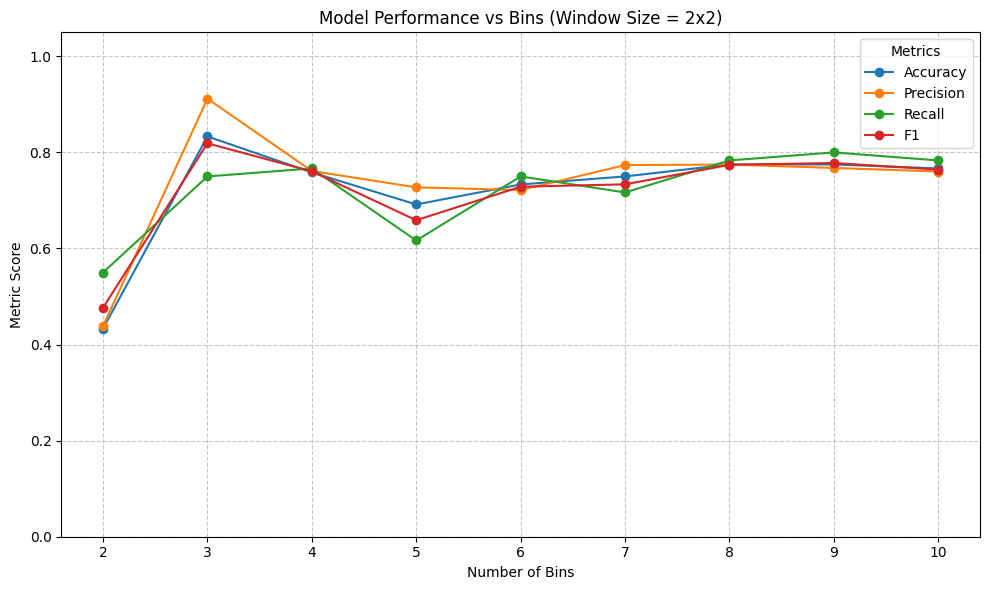

In [13]:
plt.figure(figsize=(10, 6))

for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    plt.plot(results_df['Bins'], results_df[metric], marker='o', label=metric)

plt.title('Model Performance vs Bins (Window Size = 2x2)')
plt.xlabel('Number of Bins')
plt.ylabel('Metric Score')
plt.ylim(0, 1.05)
plt.xticks(results_df['Bins'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

**No thresholding results:**

Window=(2, 2) | Threshold=None | Bins=None | Model=logistic

Accuracy: 0.7833 | Precision: 0.7804 | Recall: 0.8000 | F1: 0.7851

Confusion Matrix (summed over folds):

[[46 14]

 [12 48]]

**Best results with threshold:**

Window=(2, 2) | Threshold=0.30000000000000004 | Bins=None | Model=logistic

Accuracy: 0.8500 | Precision: 0.9292 | Recall: 0.7667 | F1: 0.8347

Confusion Matrix (summed over folds):

[[56  4]

 [14 46]]

**Best results with bins:**

Window=(2, 2) | Threshold=None | Bins=3 | Model=logistic

Accuracy: 0.8333 | Precision: 0.9118 | Recall: 0.7500 | F1: 0.8190

Confusion Matrix (summed over folds):

[[55  5]

 [15 45]]

The best bin count (3 bins) results in slightly lower accuracy compared to the thresholded model (85%), but it maintains high precision (91.18%) and offers a balanced F1 score (81.90%). The recall is lower (75%), similar to the thresholded case, but precision and F1 are better than the no-threshold baseline.

Let's try adjsuting both thresholds and bins.

#### Threshold and Bin Adjustments using 2x2 Window

In [14]:
threshold_range = list(np.arange(0.1, 1.0, 0.1))+[None]
bins_range = list(range(2, 11))+[None]

results = []

for threshold in threshold_range:
    for bins in bins_range:

        model, acc, prec, rec, f1, cm = classify_with_params(
            damaged_images,
            undamaged_images,
            window_size=(2, 2),
            threshold=threshold,
            bins=bins,
            model_type='logistic',
            n_splits=5
        )

        results.append({
            'Threshold': threshold,
            'Bins': bins,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1
        })

results_df = pd.DataFrame(results)


Window=(2, 2) | Threshold=0.1 | Bins=2 | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]
Window=(2, 2) | Threshold=0.1 | Bins=3 | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]
Window=(2, 2) | Threshold=0.1 | Bins=4 | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]
Window=(2, 2) | Threshold=0.1 | Bins=5 | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]
Window=(2, 2) | Threshold=0.1 | Bins=6 | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]
Window=(2, 2) | Threshold=0.1 | Bins=7 | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recal

In [15]:
max_acc = results_df['Accuracy'].max()
top_models_df = results_df[results_df['Accuracy'] == max_acc].reset_index(drop=True)
top_models_df


,Threshold,Bins,Accuracy,Precision,Recall,F1
0,0.3,4.0,0.875,0.866667,0.9,0.8794
1,0.3,8.0,0.875,0.866667,0.9,0.8794
2,0.4,4.0,0.875,0.866667,0.9,0.8794


**No thresholding results:**

Window=(2, 2) | Threshold=None | Bins=None | Model=logistic

Accuracy: 0.7833 | Precision: 0.7804 | Recall: 0.8000 | F1: 0.7851

Confusion Matrix (summed over folds):

[[46 14]

 [12 48]]

**Best results with threshold:**

Window=(2, 2) | Threshold=0.30000000000000004 | Bins=None | Model=logistic

Accuracy: 0.8500 | Precision: 0.9292 | Recall: 0.7667 | F1: 0.8347

Confusion Matrix (summed over folds):

[[56  4]

 [14 46]]

**Best results with bins:**

Window=(2, 2) | Threshold=None | Bins=3 | Model=logistic

Accuracy: 0.8333 | Precision: 0.9118 | Recall: 0.7500 | F1: 0.8190

Confusion Matrix (summed over folds):

[[55  5]

 [15 45]]

**Best results with bins and threshold**

Window=(2, 2) | Threshold=0.30000000000000004 | Bins=4 | Model=logistic

Accuracy: 0.8750 | Precision: 0.8667 | Recall: 0.9000 | F1: 0.8794

Confusion Matrix (summed over folds):

[[51  9]

 [ 6 54]]

Combining thresholding and binning (Threshold = 0.3, Bins = 4) produced the strongest results, with an accuracy of 87.5% and the highest F1 score at 0.8794. This setup achieved a good balance between precision and recall by minimizing both false positives and false negatives.

Let's move on to feature importance of this model.

#### Feature Importance (2x2 Window with 0.3 Threshold)

In [20]:
model, acc, prec, rec, f1, cm = classify_with_params(
    damaged_images,
    undamaged_images,
    window_size=(2, 2),
    threshold=0.3,
    bins=4,
    model_type='logistic',
    n_splits=5
)


Window=(2, 2) | Threshold=0.3 | Bins=4 | Model=logistic
Accuracy: 0.8750 | Precision: 0.8667 | Recall: 0.9000 | F1: 0.8794
Confusion Matrix (summed over folds):
[[51  9]
 [ 6 54]]


In [21]:
coeffs = model.coef_[0]

feature_names = ['Mean Entropy', 'Std Entropy', 'Min Entropy', 'Max Entropy']

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs
}).sort_values(by='Coefficient', key=abs, ascending=False).reset_index(drop=True)

importance_df


,Feature,Coefficient
0,Mean Entropy,2.148435
1,Std Entropy,0.850177
2,Max Entropy,-0.001553
3,Min Entropy,0.000000


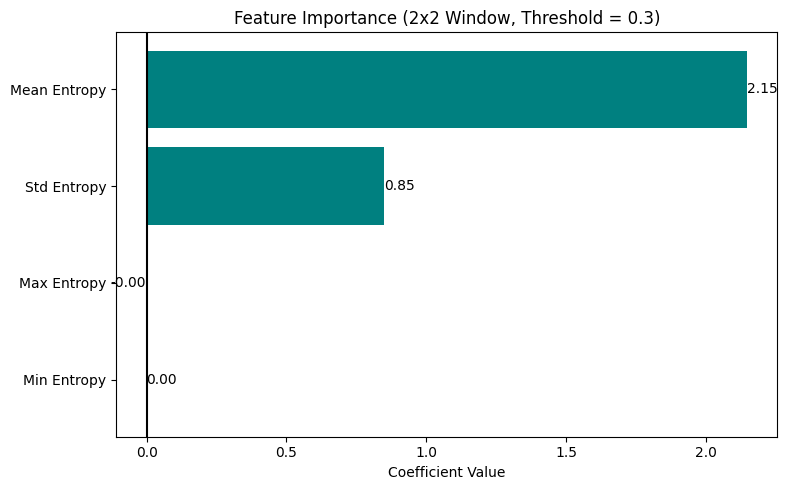

In [22]:
plt.figure(figsize=(8, 5))
bars = plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='teal')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (2x2 Window, Threshold = 0.3)')
plt.axvline(0, color='black')
plt.gca().invert_yaxis()
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
             va='center', ha='left' if bar.get_width() >= 0 else 'right')

plt.tight_layout()
plt.show()

The model relies heavily on Mean Entropy and Std Entropy. This indicated that both the average and variability of entropy in a 2x2 window are strong signals for detecting damage. Max and Min Entropy contribute almost nothing. Consider dropping these variables shouldn't change the results.

Let's check how Mean Entropy and Std Entropy of damaged and undamaged images.

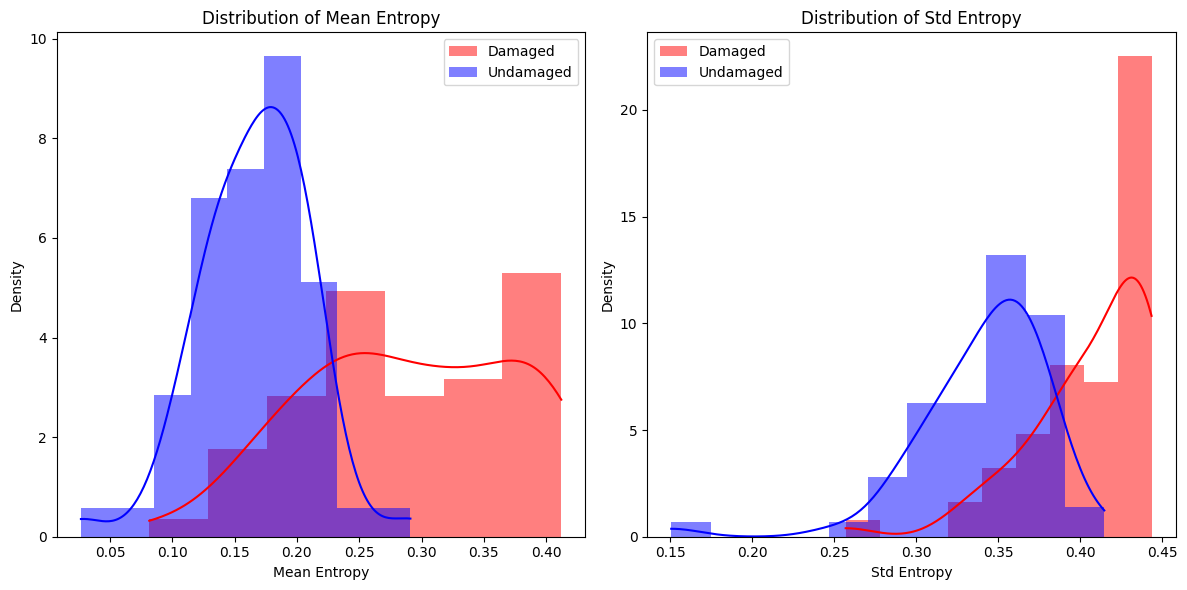

In [23]:
damaged_data = []
undamaged_data = []

for img in damaged_images:
    features = extract_entropy_features_for_image(img, window_size=(2, 2), bins=None, threshold=0.3)
    damaged_data.append(features[:2])

for img in undamaged_images:
    features = extract_entropy_features_for_image(img, window_size=(2, 2), bins=None, threshold=0.3)
    undamaged_data.append(features[:2])

damaged_df = pd.DataFrame(damaged_data, columns=['Mean Entropy', 'Std Entropy'])
undamaged_df = pd.DataFrame(undamaged_data, columns=['Mean Entropy', 'Std Entropy'])

plt.figure(figsize=(12, 6))

# Plot Mean Entropy distribution
plt.subplot(1, 2, 1)
sns.histplot(damaged_df['Mean Entropy'], kde=True, color='red', label='Damaged', stat='density', linewidth=0)
sns.histplot(undamaged_df['Mean Entropy'], kde=True, color='blue', label='Undamaged', stat='density', linewidth=0)
plt.title('Distribution of Mean Entropy')
plt.xlabel('Mean Entropy')
plt.ylabel('Density')
plt.legend()

# Plot Std Entropy distribution
plt.subplot(1, 2, 2)
sns.histplot(damaged_df['Std Entropy'], kde=True, color='red', label='Damaged', stat='density', linewidth=0)
sns.histplot(undamaged_df['Std Entropy'], kde=True, color='blue', label='Undamaged', stat='density', linewidth=0)
plt.title('Distribution of Std Entropy')
plt.xlabel('Std Entropy')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


Damaged samples tend to have higher mean entropy and higher variability in entropy (Std Entropy) compared to undamaged samples. The separation between the two categories is clearer in Mean Entropy, but there’s still overlap which suggests entropy alone may not be enough to distinguish damaged from undamaged samples.

These metrics could be useful for classification, but additional features might be needed for better accuracy due to the overlap.

### Summary

To cap it all off, allow me to answer the questions initially posed:

1. Which entropy features (e.g., mean entropy, max entropy) were most useful for classification?
    - The mean entropy and standard deviation of entropy are useful features for classification.

2. How does changing the window size affect your classifier’s performance?
    - Overall performance sees a gradual decline as window sizes increase.

3. Did thresholding or binning the grayscale values help or hurt entropy-based differentiation?
    - Thresholding with a 2x2 window and a threshold of 0.3 improved the model's performance. It increased accuracy to 85% and precision to 92.92%. Binning with 3 bins also showed good results, with an accuracy of 83.33% and precision of 91.18%. The combined binning then thresholding (threshold=0.3, bin=4) produced the best and balanced results with accuracy of 87.5% and and F1 score of 87.94%. Therefore, both thresholding and binning, when applied appropriately, can help.

4. Is there a noticeable difference in entropy distribution between damaged and undamaged images?
    - Damaged samples tend to have higher mean entropy and higher variability in entropy compared to undamaged samples. However, there is also a noticeable overlap so relying on just these two features might not be enough to appropriately classify.

5. How do you think can entropy-based classification compare to using raw pixel values or CNNs?
    - The biggest edge of this is its computational efficiency as compared to CNNs. It's faster and works on small data, unlike CNNs that require more resources and data. As a comparison for raw pixel values, the randomness that is being accounted for by the entropy makes it more robust and less senstitive to noise and abrupt pixel variations. That said, metrics-wise, I have no empirical proof which would be better since I didn't run raw pixels and CNNs.

### Appendix

What happens if it's a (1x1) window?

In [26]:
model, acc, prec, rec, f1, cm = classify_with_params(
    damaged_images,
    undamaged_images,
    window_size=(1,1),
    threshold=None,
    bins=None,
    model_type='logistic',
    n_splits=5
)

Window=(1, 1) | Threshold=None | Bins=None | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]


What happens if the threshold is 1?

In [27]:
model, acc, prec, rec, f1, cm = classify_with_params(
    damaged_images,
    undamaged_images,
    window_size=None,
    threshold=1,
    bins=None,
    model_type='logistic',
    n_splits=5
)

Window=None | Threshold=1 | Bins=None | Model=logistic
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix (summed over folds):
[[60  0]
 [60  0]]
